<a href="https://colab.research.google.com/github/yongzhiqu/FRF-Learning-with-Few-Shot-Multivariate-Regression/blob/main/midterm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


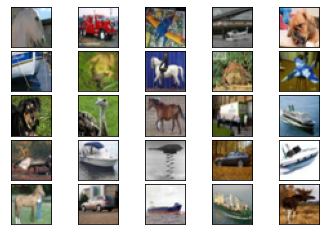

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = '/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py'

    train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data(cifar_10_dir)

    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    f, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, train_data.shape[0])
            ax[m, n].imshow(train_data[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)
    plt.show()

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
# convert data from RGB to gray, each pixel from the 32 x 32 image are covernted 3 dimensional to 1 dimensional
train_data_gray = rgb2gray(train_data)
test_data_gray = rgb2gray(test_data)

print("Train data gray: ", train_data_gray.shape)
print("Test data gray: ", test_data_gray.shape)

Train data gray:  (50000, 32, 32)
Test data gray:  (10000, 32, 32)


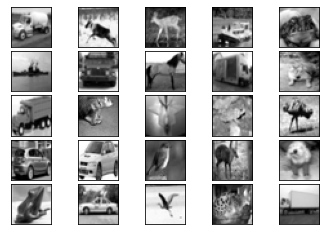

In [5]:
# Plot and check again

num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data_gray.shape[0])
        ax[m, n].imshow(train_data_gray[idx], cmap='gray')
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

In [6]:
# Convert data to 1D by rashping the data from 50000 x 32 x 32 into 50000 x 1024
train_data_gray_1d = train_data_gray.reshape(50000, 1024)
test_data_gray_1d = test_data_gray.reshape(10000, 1024)

print("Train data gray 1D: ", train_data_gray_1d.shape)
print("Test data gray 1D: ", test_data_gray_1d.shape)

Train data gray 1D:  (50000, 1024)
Test data gray 1D:  (10000, 1024)


In [7]:
# check label

print(train_labels[1:100])

[9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3 7
 3 3 5 2 2 7 1 1 1 2 2 0 9 5 7 9 2 2 5 2 4 3 1 1 8 2 1 1 4 9 7 8 5 9 6 7 3
 1 9 0 3 1 3 5 4 5 7 7 4 7 9 4 2 3 8 0 1 6 1 1 4 1]


In [14]:
u, sigma, vt = np.linalg.svd(train_data_gray_1d[0:20000], full_matrices = 'false')